<a href="https://colab.research.google.com/github/gverafei/scraping/blob/main/scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Investigating how to scrape the web**
April 2025



### Initial method

<center><img src="images/metodo.jpg" style="margin:auto; width:80%"/></center>

----

### Método propuesto sin RAG

<center><img src="images/metodo-slim1.jpg" style="margin:a6to; width:60%"/></center>

----

### Método propuesto con RAG

<center><img src="images/metodo-slim2.jpg" style="margin:auto; width:80%"/></center>


### Crawling WCAG para el método con RAG

Necesitamos guardar de alguna manera todo este conocimiento: https://www.w3.org/WAI/WCAG22/Understanding/

O este conocimiento: https://www.w3.org/WAI/standards-guidelines/act/rules/

<center><img src="images/metodo-craw.jpg" style="margin:auto; width:50%"/></center>


### Retrieval-Augmented Generation (RAG)

<center><img src="images/rag.gif" style="margin:auto; width:50%"/></center>

### Agentic Retrieval-Augmented Generation (RAG)

<center><img src="images/arag.gif" style="margin:auto; width:50%"/></center>

### Chunking strategies

<center><img src="images/chunks.gif" style="margin:auto; width:50%"/></center>

## Configure virtual environment

Solo se ejecuta lo siguiente la primera vez. Pedirá seleccionar the kernel from the upper right corner. Choose this virtual environment we just created.

In [1]:
# !python3 -m venv .venv
# !source .venv/bin/activate # Linux/Mac
# !.\venv\Scripts\activate # Windows

Inicializa el repositorio en GitHub. Todo esto se hace desde la terminal.

In [2]:
# !git init
# !git remote add origin https://github.com/gverafei/scraping.git
# !git pull origin main
# git add .
# git commit -m "Initial commit"
# git push --set-upstream origin main

In [3]:
!pip install --upgrade pip --quiet

## Create the initial data

In [ ]:
test_sites = [
    # {
    #     "name": "Amazon",
    #     "url": "https://www.amazon.com"
    # },
    # {
    #     "name": "UV",
    #     "url": "https://www.uv.mx"
    # },
    # {
    #     "name": "W3C ACT Rules",
    #     "url": "https://www.w3.org/WAI/standards-guidelines/act/rules/"
    # },
    # {
    #     "name": "W3C WCAG 2.2",
    #     "url": "https://www.w3.org/WAI/WCAG22/Understanding/"
    # },
    # {
    #     "name": "Chedrahui",
    #     "url": "https://www.chedraui.com.mx"
    # },
    # FEI demo sites
    # {
    #     "name": "Form",
    #     "url": "https://sistemasfei.uv.mx/aulaclase/"
    # },
    # {
    #     "name": "Blocks",
    #     "url": "https://sistemasfei.uv.mx/inicio/"
    # }
    # WCAG Before and After Demos
    # {
    #     "name": "HomePage",
    #     "url": "https://www.w3.org/WAI/demos/bad/before/home.html"
    # },
    # {
    #     "name": "News",
    #     "url": "https://www.w3.org/WAI/demos/bad/before/news.html"
    # },
    # {
    #     "name": "Tickets",
    #     "url": "https://www.w3.org/WAI/demos/bad/before/tickets.html"
    # },
    # {
    #     "name": "Survey",
    #     "url": "https://www.w3.org/WAI/demos/bad/before/survey.html"
    # }
    # Washintgton and Duke Before and After Demos
    {
        "name": "Site 1",
        "url": "https://www.washington.edu/accesscomputing/AU/before.html"
    },
    {
        "name": "Site 2",
        "url": "https://openassessittoolkit.github.io/accessible_u/before_u.html"
    },
]

## Setup cost's calculations

The idea is to compare side-by-side.

We can calculate how much it'll cost by using OpenAI's `tiktoken` library from: https://github.com/openai/tiktoken

And costs from: https://openai.com/api/pricing/

In [5]:
!pip install tiktoken --quiet

In [6]:
import tiktoken

def count_tokens(input_string: str) -> int:
    encoder = tiktoken.encoding_for_model("gpt-4o")
    tokens = encoder.encode(input_string)
    return len(tokens)

def calculate_cost(input_string: str, cost_per_million_tokens: float = 2.5) -> tuple:
    num_tokens = count_tokens(input_string)
    total_cost = (num_tokens / 1_000_000) * cost_per_million_tokens
    return total_cost, num_tokens

def calculate_cost_tokens(num_tokens: int, cost_per_million_tokens: float = 2.5) -> float:
    total_cost = (num_tokens / 1_000_000) * cost_per_million_tokens
    return total_cost

# Example usage:
# input_string = "Porque la gallina cruzó el camino? Pues porque quería llegar al otro lado."
# cost = calculate_cost(input_string)
# print(f"The total cost for using gpt-4o is: $US {cost:.6f}")

## Table para ver los resultados

Ahora, para ver los resultados de la comparaciones, instalamos un paquete para ver tablas en línea de comandos: https://pypi.org/project/prettytable/

Y también instalamos un paquete para ver una barra de progreso bonita en loops: https://pypi.org/project/tqdm/

In [7]:
!pip install prettytable --quiet

In [8]:
!pip install tqdm --quiet

In [9]:
from typing import List, Callable, Dict
from prettytable import PrettyTable
from tqdm.auto import tqdm

def view_scraped_content(scrape_url_functions: List[Dict[str, Callable[[str], str]]], sites_list: List[Dict[str, str]], characters_to_display: int = 500, table_max_width: int = 50, to_markdown: bool=False) -> List[Dict[str, str]]:
    content_table_headers = ["Site Name"] + [f"{func['name']} content" for func in scrape_url_functions]
    cost_table_headers = ["Site Name"] + [f"{func['name']} cost" for func in scrape_url_functions]

    content_table = PrettyTable()
    content_table.field_names = content_table_headers

    cost_table = PrettyTable()
    cost_table.field_names = cost_table_headers

    scraped_data = []

    for site in sites_list:
        content_row = [site['name']]
        cost_row = [site['name']]
        site_data = {"provider": site['name'], "sites": []}

        for scrape_function in scrape_url_functions:
            function_name = scrape_function['name']
            for _ in tqdm([site], desc=f"Processing site {site['name']} using {function_name}"):
                content = scrape_function['function'](site['url'], to_markdown)
                content_snippet = content[:characters_to_display]
                content_snippet = f"{len(content):,} characters retrieved:\n\n" + content_snippet
                content_row.append(content_snippet)

                cost, count_tokens = calculate_cost(content)
                cost_row.append(f"${cost:.6f} (tokens: {count_tokens:,})")

                site_data["sites"].append({"name": function_name, "content": content, "url": site['url']})

        content_table.add_row(content_row)
        cost_table.add_row(cost_row)
        scraped_data.append(site_data)

    content_table.max_width = table_max_width
    content_table.hrules = True

    cost_table.max_width = table_max_width
    cost_table.hrules = True

    print("Content Table:")
    print(content_table)

    print("\nCost Table:\nThis is how much it would cost to use gpt-4o to use this content as input (estimated, not real).")
    print(cost_table)

    return scraped_data

Libreria para leer los secretos

In [10]:
!pip install env-colab-pass --quiet

## Setup all the scrapers

Let's setup all of our scrapers.

## Beautiful Soup

Se instala este paquete desde: https://pypi.org/project/beautifulsoup4/

Y también request para hacer peticiones desde: https://pypi.org/project/requests/

In [11]:
!pip install requests beautifulsoup4 --quiet

In [12]:
!pip install markdownify --quiet

In [13]:
# Beautiful Soup utility functions

import requests
from bs4 import BeautifulSoup
from markdownify import markdownify as md

def beautiful_soup_scrape_url(url: str, to_markdown: bool = False) -> str:
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    if to_markdown:
        return md(str(soup)) # Convert to markdown
    return str(soup)

## Playwright

La manera clásica de hacer scraping. No es especial para LLMs desde: https://playwright.dev/

In [14]:
!pip install playwright --quiet

In [15]:
!playwright install

In [16]:
!pip install nest_asyncio --quiet

In [17]:
!pip install markdownify --quiet

In [18]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from playwright.async_api import async_playwright

async def scrape_playwright(url: str, to_markdown: bool = False) -> str:
    async with async_playwright() as pw:
        browser =  await pw.chromium.launch(headless=True)
        page = await browser.new_page()
        await page.goto(url)
        # Espera para que cargue la pagina
        await page.wait_for_load_state('domcontentloaded')
        # Ejecuta un script para bajar hasta el final de la pagina
        # await page.evaluate('window.scrollTo(0, document.body.scrollHeight)')
        # Tambien se puede hacer con el teclado
        await page.keyboard.press('End')
        # Espera a que baje el scroll
        await page.wait_for_timeout(2000)

        html = await page.content()
        if to_markdown:
            html = md(html) # Convert to markdown
        
        await browser.close()
        return html

def scrape_playwright_sync(url: str, to_markdown: bool = False):
    return asyncio.run(scrape_playwright(url, to_markdown))

# print(scrape_playwright_sync("https://www.amazon.com", to_markdown=True))

## Reader API by Jina AI

Este es especialmente para LLMs también. Setup Jina AI's scrape method from: https://jina.ai/reader/

In [19]:
import requests

def scrape_jina_ai(url: str, to_markdown: bool = False) -> str:
    headers = {
        'Authorization': 'jina_db75e513620a46edaaf6023f105928ffn4azQ0XslqlqPmx6xgkxXuk1GCet',
        'X-Return-Format': 'markdown' if to_markdown else 'html',
        'X-Engine': 'browser',
        'X-Timeout': '30',
        "X-With-Images-Summary": "none" if to_markdown else "all",
    }
    data = {
        'url': url,
        'injectPageScript': [
            'document.addEventListener("mutationIdle", window.simulateScroll);'
        ]
    }
    response = requests.post('https://r.jina.ai/', headers=headers, json=data)
    return response.text

# print(scrape_jina_ai("https://www.uv.mx", to_markdown = True))

## Crawl4AI: Open-Source LLM-Friendly Web Crawler & Scraper

Este es especialmente para obtener formato amigable para LLMs desde: https://docs.crawl4ai.com/

Primero instalamos prerequisitos que requiere Google Colab.

In [20]:
!pip install h5py --quiet

In [21]:
!pip install typing-extensions --quiet

In [22]:
!pip install wheel --quiet

Posteriormente, ya podemos realizar la instalación.

In [23]:
!pip install crawl4ai --quiet

In [24]:
!crawl4ai-setup

[INIT].... → Running post-installation setup...
[INIT].... → Installing Playwright browsers...
[COMPLETE] ● Playwright installation completed successfully.
[INIT].... → Starting database initialization...
[COMPLETE] ● Database initialization completed successfully.
[COMPLETE] ● Post-installation setup completed!


In [25]:
!pip install nest_asyncio --quiet

In [26]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from crawl4ai import AsyncWebCrawler
from crawl4ai.async_configs import BrowserConfig, CrawlerRunConfig

browser_conf = BrowserConfig(verbose=False,headless=True)

run_cfg = CrawlerRunConfig(
    wait_until="domcontentloaded",
    wait_for_images=True,
    scan_full_page=True,
    verbose=False,
)

async def async_scrape_crawl4ai(url: str, to_markdown: bool = False) -> str:
    crawler = AsyncWebCrawler(config=browser_conf)
    await crawler.start()
    result = await crawler.arun(
        url=url,
        config=run_cfg,
    )

    if not to_markdown:
        return result.html
    
    # Convert HTML to Markdown
    # Get all the images
    images = result.media.get("images", [])
    images_list = f"\n\nImages found:{len(images)}"
    for i, img in enumerate(images):
        images_list = images_list + f"\n - ![Image {i+1}: {img.get('alt','No description')}]({img.get('src','')})"
        # Example: - ![Image 1: Alt text](https://example.com/image1.jpg)
    
    return result.markdown + images_list

# To run the async function in a synchronous context
# (like this script), you can use asyncio.run() to execute it.
# This is a workaround for running async functions in a sync context.
def scrape_crawl4ai(url: str, to_markdown: bool = False):
    return asyncio.run(async_scrape_crawl4ai(url, to_markdown))

# print(scrape_crawl4ai("https://www.uv.mx", to_markdown=True))

## Firecrawl: Turn websites into LLM-ready data

Esta es otra opción que no se usará porque tiene costo. También esta enfocado en AI. Desde: https://www.firecrawl.dev/

In [27]:
from env_colab_pass import passutil 
import requests
import json

FIRECRAWL_API_KEY = passutil.get_secret_value("FIRECRAWL_API_KEY")

def scrape_firecrawl(url: str, to_markdown: bool = False) -> str:    
    payload = {
        'url': url,
        'formats': ['html' if not to_markdown else 'markdown'],
        'waitFor': 2000,
        'actions': [
            {
                "type": "executeJavascript", "script": "window.scrollTo(0, document.body.scrollHeight)",
                "type": "wait", "milliseconds": 2000,
            }
        ]
    }
    headers = {
        "Authorization": "Bearer " + FIRECRAWL_API_KEY,
        "Content-Type": "application/json"
    }

    response = requests.request("POST", "https://api.firecrawl.dev/v1/scrape", json=payload, headers=headers)
    scrape_result = json.loads(response.text)

    # Get the content
    if not to_markdown:
        return scrape_result['data']['html']
    else:
        return scrape_result['data']['markdown']
    
# res = scrape_firecrawl("https://www.uv.mx", to_markdown=False)
# print(res)

## Main functions to run the comparasion with HTML

Let's run all the scrapers and display them in our comparison table.

In [28]:
list_of_scraper_functions = [
      {"name": "Beautiful Soup", "function": beautiful_soup_scrape_url},
      {"name": "Jina AI", "function": scrape_jina_ai},
      {"name": "Playwright", "function": scrape_playwright_sync},
      {"name": "Firecrawl", "function": scrape_firecrawl},
      {"name": "Crawl4ai", "function": scrape_crawl4ai},
]

all_content_html = view_scraped_content(list_of_scraper_functions, test_sites, 35000, 35, to_markdown=False)

Processing site WashintgtonUniversityHomePage using Beautiful Soup:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site WashintgtonUniversityHomePage using Jina AI:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site WashintgtonUniversityHomePage using Playwright:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site WashintgtonUniversityHomePage using Firecrawl:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site WashintgtonUniversityHomePage using Crawl4ai:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site DukeUniversityHomePage using Beautiful Soup:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site DukeUniversityHomePage using Jina AI:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site DukeUniversityHomePage using Playwright:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site DukeUniversityHomePage using Firecrawl:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site DukeUniversityHomePage using Crawl4ai:   0%|          | 0/1 [00:00<?, ?it/s]

Content Table:
+-------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+
|           Site Name           |        Beautiful Soup content       |           Jina AI content           |          Playwright content         |          Firecrawl content          |           Crawl4ai content          |
+-------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+
| WashintgtonUniversityHomePage |     10,367 characters retrieved:    |     12,237 characters retrieved:    |     12,252 characters retrieved:    |     11,083 characters retrieved:    |     12,393 characters retrieved:    |
|                               |                                     |                  

Se guarda el resultado de `Crawl4ai` en HTML para su futura comparación

In [29]:
import os

def generate_output_scrape_file(prefix: str, content: str):
    # Create the output directory if it doesn't exist
    if not os.path.exists("output/original"):
        os.makedirs("output/original")

    # Write the HTML content to files
    with open(f'output/original/{prefix}-original.html', 'w', encoding='utf-8') as f:
        f.write(content)

# Save the scraped content to files
for items in all_content_html:
    for site in items["sites"]:
        if site["name"] == "Crawl4ai":
            generate_output_scrape_file(items["provider"], site["content"])

## Realizamos la comparación con markdown

Vamos a ejecutar todos los scrapers pero ahora que devuelvan un formato más amigable para la IA.

In [30]:
all_content_md = view_scraped_content(list_of_scraper_functions, test_sites, 1200, 35, to_markdown=True)

Processing site WashintgtonUniversityHomePage using Beautiful Soup:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site WashintgtonUniversityHomePage using Jina AI:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site WashintgtonUniversityHomePage using Playwright:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site WashintgtonUniversityHomePage using Firecrawl:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site WashintgtonUniversityHomePage using Crawl4ai:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site DukeUniversityHomePage using Beautiful Soup:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site DukeUniversityHomePage using Jina AI:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site DukeUniversityHomePage using Playwright:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site DukeUniversityHomePage using Firecrawl:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site DukeUniversityHomePage using Crawl4ai:   0%|          | 0/1 [00:00<?, ?it/s]

Content Table:
+-------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+
|           Site Name           |        Beautiful Soup content       |           Jina AI content           |          Playwright content         |          Firecrawl content          |           Crawl4ai content          |
+-------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+
| WashintgtonUniversityHomePage |     5,055 characters retrieved:     |     8,005 characters retrieved:     |     5,055 characters retrieved:     |     5,530 characters retrieved:     |     6,962 characters retrieved:     |
|                               |                                     |                  

## Conectar con los LLMs para evaluar si puede crear una página web accesible

Vamos a enviar el contenido en HTML y en markdown y le vamos a pedir que nos devuelva una sección accesible WCAG 2.2.

In [31]:
!pip install openai --quiet

In [106]:
from env_colab_pass import passutil 
from openai import OpenAI

OPENAI_API_KEY = passutil.get_secret_value("OPENAI_API_KEY")
GOOGLE_API_KEY = passutil.get_secret_value("GOOGLE_API_KEY")

def extract(model: str, user_input: str, user_prompt: str, template: str = None) -> str:
    if model.startswith("gpt"):
        client = OpenAI(api_key=OPENAI_API_KEY)
    elif model.startswith("gemini"):
        client = OpenAI(api_key=GOOGLE_API_KEY, base_url="https://generativelanguage.googleapis.com/v1beta/openai/")

    entity_extraction_system_message = {
        "role": "system", 
        "content": """"
        1. You are a helpful assistant expert on web accessibility WCAG that evaluate and correct HTML code.
        2. You will be given code and you will analize it.
        3. Then, you will create a new webpage from that code but accessible according to WCAG https://www.w3.org/WAI/WCAG22/Understanding/
        4. Revise all WCAG 2.2 rules including color contrast, alt text, aria labels, provide correct heading levels starting from h1, use semantic HTML elements. Dont broke aria references. Correct as necessary the HTML code to make it accessible.
        5. If the images, scripts, css and font files have a relative urls, convert them to absoulute urls respeting the relative path. If the images, scripts, css and font files have absolute urls, you will keep them as they are.
        6. If the original source has required scripts, you will include them in the head section. If the original source has required css files, you will analize them and include them as inline rules in head section but WCAG accessible corrected, including color contrast checking. Correct as necessary the CSS code to make it accessible.
        7. If you need to include an style.css file, you will add the rules inline in the head section. If you include an sr-only rule, add it to the style section to hide the elements.
        8. Detect the language of the HTML code and add the lang attribute to the html tag.
        9. Before returning the HTML code, you will analyze it and check if it accessible according to WCAG 2.2. If it is not accessible, you will correct it and return the corrected code.
        10. You will double check every step you do. 
        11. You will provide a numbered list lower than 20 lines in simple plain text (without double quotes or any other special char) of the procedure fixes and improvements you made.
        12. The HTML code must be a complete HTML code, not a fragment or incomplete and must be within the context window of the model.
        13. You will return the result as a valid JSON object with values: {HTML: str, Procedure: str}. Double check the JSON object and make sure it is format valid. Sometimes you misses the slash before double quotes.
        14. If you find any error in the JSON object, you will correct it and return the corrected JSON object.
        """
    }
    # Add the system message to the messages list
    messages = [entity_extraction_system_message]
    # Add the content to the messages list
    messages.append({"role": "user", "content": user_prompt})
    messages.append({"role": "user", "content": user_input})
    if template:
        messages.append({"role": "user", "content": "The following is a template as a base for the HTML code you will generate with the content. Use bootstrap classes to make it responsive and accessible. " + template})
        messages.append({"role": "user", "content": template})
    # Call the OpenAI API to get the response
    response = client.chat.completions.create(
        model=model,
        temperature=0.1,
        stream=False,
        messages=messages,
        response_format={"type": "json_object"},
    )
    
    # return response.choices[0].message.content
    return response.choices[0].message.content, response.usage.completion_tokens, response.usage.prompt_tokens

## Función que permite comparar los resultados

Ahora se crearemos una función para crear una tabla con los resultados de comparar el resultado devuelto en HTML y en Markdown. 

In [192]:
def display_extracted_content(model: str, results_html: List[Dict[str, any]], results_md: List[Dict[str, any]], function_name: str, site_name: str, template: str):
    table = PrettyTable()
    table.field_names = ["Site", "From HTML", "From HTML with template","From markdown", "From markdown with template"]

    with open(f'templates/{template}.html', 'r') as file:  # r to open file in READ mode
        html_as_string = file.read()

    # Iterate through each site and its content
    for item in tqdm(results_html, desc="Processing results"):
        sites_html = item["sites"]
        sites_md = item["sites"]
        provider = item["provider"]

        # Check if the provider matches the site name
        if provider == site_name:
            for i in range(len(sites_html)):
                # Check if the function name matches
                if sites_html[i]["name"] == function_name:
                    # Extract the content for HTML and Markdown
                    content_html = sites_html[i]["content"]
                    content_url = sites_html[i]["url"]
                    content_md = sites_md[i]["content"]

                    # Progress bar for each function
                    for _ in tqdm(range(1), desc=f"Extracting content with {function_name} for HTML input", position=0, leave=True):
                        extracted_content_html, completion_tokens, prompt_tokens = extract(model, content_html, f"Use the following code and create a new accessible web page version mantaining all the contents. The root URL is '{content_url}'.", template=None)
                        cost = calculate_cost_tokens(completion_tokens + prompt_tokens)
                        cost_label = f"Completion tokens: {completion_tokens:,}\nPrompt tokens: {prompt_tokens:,}\nTotal cost: ${cost:.6f}" + "\n\n\n"
                        col_content_html = cost_label + extracted_content_html
                    
                    # Progress bar for each function
                    for _ in tqdm(range(1), desc=f"Extracting content with {function_name} for HTML input and template"):
                        extracted_content_html_template, completion_tokens, prompt_tokens = extract(model, content_html, f"Use the following content to create a new accessible web page version mantaining all the contents. The root URL is '{content_url}'.",html_as_string.replace("\n",""))
                        cost = calculate_cost_tokens(completion_tokens + prompt_tokens)
                        cost_label = f"Completion tokens: {completion_tokens:,}\nPrompt tokens: {prompt_tokens:,}\nTotal cost: ${cost:.6f}" + "\n\n\n"
                        col_content_html_template = cost_label + extracted_content_html_template

                    # Progress bar for each function
                    for _ in tqdm(range(1), desc=f"Extracting content with {function_name} for Markdown input"):
                        extracted_content_md, completion_tokens, prompt_tokens = extract(model, content_md, f"Use the following content to create a new accessible web page version. The root URL is '{content_url}'. Use the HTML code source of the page https://webaim.org/ as a base to create a new accessible web page version. Observe the structure of the header, the images are in on row with the title; also the use of cols and rows to make it responsive and accessible.", template=None)
                        cost = calculate_cost_tokens(completion_tokens + prompt_tokens)
                        cost_label = f"Completion tokens: {completion_tokens:,}\nPrompt tokens: {prompt_tokens:,}\nTotal cost: ${cost:.6f}" + "\n\n\n"
                        col_content_md = cost_label + extracted_content_md

                    # Progress bar for each function
                    for _ in tqdm(range(1), desc=f"Extracting content with {function_name} for Markdown input and template"):
                        extracted_content_md_template, completion_tokens, prompt_tokens = extract(model, content_md, f"Use the following content to create a new accessible web page version. The root URL is '{content_url}'.",html_as_string.replace("\n",""))
                        cost = calculate_cost_tokens(completion_tokens + prompt_tokens)
                        cost_label = f"Completion tokens: {completion_tokens:,}\nPrompt tokens: {prompt_tokens:,}\nTotal cost: ${cost:.6f}" + "\n\n\n"
                        col_content_md_template = cost_label + extracted_content_md_template

                    table.add_row([provider, col_content_html, col_content_html_template, col_content_md, col_content_md_template])

    table.max_width = 50  # Set the maximum width for better display
    table.hrules = True  # Add horizontal rules for better readability

    print("Extracted Content Table:")
    print(table)

    return extracted_content_html, extracted_content_html_template, extracted_content_md, extracted_content_md_template

### Rutinas para visualizar los resultados obtenidos

Instalamos las dependencias necesarias para generar la interface web.

In [34]:
!pip install ipywidgets --quiet

In [36]:
!pip install aiofiles --quiet

In [37]:
!pip install gradio --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
crawl4ai 0.5.0.post8 requires aiofiles>=24.1.0, but you have aiofiles 23.2.1 which is incompatible.


Creamos una función de apoyo para crear la interface web y poder ver los resultados visualmente.

In [38]:
import gradio as gr

def create_interface(extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template):

    with gr.Blocks(theme=gr.themes.Default()) as demo:
        # From HTML
        with gr.Tab("Proc HTML"):
            gr.TextArea(extracted_json_html["Procedure"], label="Procedure")
        with gr.Tab("Code HTML"):
            gr.TextArea(extracted_json_html["HTML"], label="HTML code", show_copy_button=True, lines=20)
        with gr.Tab("Proc HTML with template"):
            gr.TextArea(extracted_json_html_template["Procedure"], label="Procedure")
        with gr.Tab("Code MD with template"):
            gr.TextArea(extracted_json_html_template["HTML"], label="HTML code", show_copy_button=True, lines=20)
        with gr.Tab("Proc MD"):
            gr.TextArea(extracted_json_md["Procedure"], label="Procedure")
        with gr.Tab("Code MD"):
            gr.TextArea(extracted_json_md["HTML"], label="HTML code", show_copy_button=True, lines=20)
        with gr.Tab("Proc MD with template"):
            gr.TextArea(extracted_json_md_template["Procedure"], label="Procedure")
        with gr.Tab("Code MD with template"):
            gr.TextArea(extracted_json_md_template["HTML"], label="HTML code", show_copy_button=True, lines=20)

    demo.launch()

In [76]:
import os

def generate_output_files(prefix: str, extracted_json_html: dict, extracted_json_html_template: dict, extracted_json_md: dict, extracted_json_md_template: dict):
    # Create the output directory if it doesn't exist
    if not os.path.exists(f"output/{prefix}"):
        os.makedirs(f"output/{prefix}")

    # Write the HTML content to files
    with open(f'output/{prefix}/1-from_html.html', 'w', encoding='utf-8') as f:
        f.write(extracted_json_html["HTML"])

    with open(f'output/{prefix}/2-from_html_template.html', 'w', encoding='utf-8') as f:
        f.write(extracted_json_html_template["HTML"])

    with open(f'output/{prefix}/3-from_md.html', 'w', encoding='utf-8') as f:
        f.write(extracted_json_md["HTML"])

    with open(f'output/{prefix}/4-from_md_template.html', 'w', encoding='utf-8') as f:
        f.write(extracted_json_md_template["HTML"])

## GPT-4o: Washington University Site

Revisemos el resultado que produce este modelo.

In [ ]:
# extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template = display_extracted_content("gpt-4o", all_content_html, all_content_md, "Crawl4ai", "Blocks", "blocks")
extracted_html, extracted_html_template, extracted_md, extracted_md_template = display_extracted_content("gpt-4o", all_content_html, all_content_md, "Crawl4ai", site_name="Site 1", template="blocks")

Processing results:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracted Content Table:
+-------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
|              Site             |                     From HTML                      |              From HTML with template               |                   From markdown                    |            From markdown with template             |
+-------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
| WashintgtonUniversityHomePage |              Completion tokens: 4,901              |              Completion tokens: 3,572              |              Completion tokens: 4,415              |              Completion tokens: 3,507       

Se obtienen los objetos JSON

In [58]:
extracted_json_html = json.loads(extracted_html)
extracted_json_html_template = json.loads(extracted_html_template)
extracted_json_md = json.loads(extracted_md)
extracted_json_md_template = json.loads(extracted_md_template)

In [ ]:
# Esto solo si queremos mostrar el resultado en la interfaz de gradio
create_interface(extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template)

In [ ]:
generate_output_files("gpt-site1", extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template)

## Google Gemini: Washington University Site 

Revisemos el resultado que produce este modelo.

In [ ]:
extracted_html, extracted_html_template, extracted_md, extracted_md_template = display_extracted_content("gemini-2.5-flash-preview-04-17", all_content_html, all_content_md, "Crawl4ai", site_name="Site 1", template="blocks")

Processing results:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracted Content Table:
+-------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
|              Site             |                     From HTML                      |              From HTML with template               |                   From markdown                    |            From markdown with template             |
+-------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
| WashintgtonUniversityHomePage |              Completion tokens: 8,528              |              Completion tokens: 7,794              |              Completion tokens: 7,260              |              Completion tokens: 9,446       

In [108]:
extracted_json_html = json.loads(extracted_html)
extracted_json_html_template = json.loads(extracted_html_template)
extracted_json_md = json.loads(extracted_md)
extracted_json_md_template = json.loads(extracted_md_template)

In [ ]:
create_interface(extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template)

In [109]:
generate_output_files("gemini-site1", extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template)

## GPT-4o: Duke University Site

Revisemos el resultado que produce este modelo.

In [ ]:
extracted_html, extracted_html_template, extracted_md, extracted_md_template = display_extracted_content("gpt-4o", all_content_html, all_content_md, "Crawl4ai", site_name="Site 2", template="blocks")

Processing results:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracted Content Table:
+------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
|          Site          |                     From HTML                      |              From HTML with template               |                   From markdown                    |            From markdown with template             |
+------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
| DukeUniversityHomePage |              Completion tokens: 6,860              |              Completion tokens: 4,243              |              Completion tokens: 5,012              |              Completion tokens: 4,246              |
|                  

In [189]:
extracted_json_html = json.loads(extracted_html)
extracted_json_html_template = json.loads(extracted_html_template)
extracted_json_md = json.loads(extracted_md)
extracted_json_md_template = json.loads(extracted_md_template)

In [190]:
generate_output_files("gpt-site2", extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template)

## Google Gemini: Duke University Site

Revisemos el resultado que produce este modelo.

In [ ]:
extracted_html, extracted_html_template, extracted_md, extracted_md_template = display_extracted_content("gemini-2.5-flash-preview-04-17", all_content_html, all_content_md, "Crawl4ai", site_name="Site 2", template="blocks")

Processing results:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracted Content Table:
+------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
|          Site          |                     From HTML                      |              From HTML with template               |                   From markdown                    |            From markdown with template             |
+------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
| DukeUniversityHomePage |             Completion tokens: 11,108              |              Completion tokens: 6,137              |              Completion tokens: 8,838              |              Completion tokens: 7,786              |
|                  

In [ ]:
extracted_json_html = json.loads(extracted_html)
extracted_json_html_template = json.loads(extracted_html_template)
extracted_json_md = json.loads(extracted_md)
extracted_json_md_template = json.loads(extracted_md_template)

In [187]:
generate_output_files("gemini-site2", extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template)

---
## Evaluación de los resultados

Los resultados se encuentran en la carpeta ouput y ahora hay que utilizar la herramienta WAVE y Lighthouse para evaluar la accesibilidad utilizando la metodología WCAG-EM. A continuación hay que colocar los resultados de las evaluaciones.

### Paso 1: Armar el DataFrame

In [197]:
# Paso 1: Estructura de costos con claves únicas
costs = {
    "GPT_Site1_html": {"ptokens": 3804, "ctokens": 4901, "cost": 0.021762},
    "GPT_Site1_html_template": {"ptokens": 5151, "ctokens": 3572, "cost": 0.021808},
    "GPT_Site1_md": {"ptokens": 3857, "ctokens": 4415, "cost": 0.020680},
    "GPT_Site1_md_template": {"ptokens": 5146, "ctokens": 3507, "cost": 0.021632},

    "Gem_Site1_html": {"ptokens": 3890, "ctokens": 8528, "cost": 0.031045},
    "Gem_Site1_html_template": {"ptokens": 5235, "ctokens": 7794, "cost": 0.032573},
    "Gem_Site1_md": {"ptokens": 3943, "ctokens": 7260, "cost": 0.028007},
    "Gem_Site1_md_template": {"ptokens": 5230, "ctokens": 9446, "cost": 0.036690},

    "GPT_Site2_html": {"ptokens": 4475, "ctokens": 6860, "cost": 0.028337},
    "GPT_Site2_html_template": {"ptokens": 5822, "ctokens": 4243, "cost": 0.025162},
    "GPT_Site2_md": {"ptokens": 4528, "ctokens": 5012, "cost": 0.023850},
    "GPT_Site2_md_template": {"ptokens": 5817, "ctokens": 4246, "cost": 0.025158},

    "Gem_Site2_html": {"ptokens": 4583, "ctokens": 11108, "cost": 0.039227},
    "Gem_Site2_html_template": {"ptokens": 5928, "ctokens": 6137, "cost": 0.030162},
    "Gem_Site2_md": {"ptokens": 4636, "ctokens": 8838, "cost": 0.033685},
    "Gem_Site2_md_template": {"ptokens": 5923, "ctokens": 7786, "cost": 0.034273},
}

# Paso 2: Calcular y agregar TotalTokens
for entry in costs.values():
    entry["totaltokens"] = entry["ptokens"] + entry["ctokens"]


In [200]:
import pandas as pd

# Puntos base de referencia (originales sin remediar)
original_lighthouse_scores = {
    'Site 1': 69,
    'Site 2': 58
}

# Datos originales de los sitios (según el reporte inicial)
original_wave_metrics = {
    'Site 1': {'WAVEErrors': 16, 'WAVEContrastErrors': 4, 'WAVEAlerts': 11, 'WAVEFeatures': 1},
    'Site 2': {'WAVEErrors': 24, 'WAVEContrastErrors': 21, 'WAVEAlerts': 11, 'WAVEFeatures': 3}
}

# Lista de combinaciones que vamos a mapear a mano (modelo, sitio, entrada, template, otras métricas)
combinations = [
    # Model, Site, InputType, TemplateUsed, AccessibilityScore, WAVE Errors, Contrast, Alerts, Features, cost_key
    ['GPT-4o', 'Site 1', 'HTML', 'No', 96, 2, 0, 9, 20, 'GPT_Site1_html'],
    ['GPT-4o', 'Site 1', 'HTML', 'Yes', 100, 1, 3, 6, 20, 'GPT_Site1_html_template'],
    ['GPT-4o', 'Site 1', 'Markdown', 'No', 96, 1, 0, 5, 20, 'GPT_Site1_md'],
    ['GPT-4o', 'Site 1', 'Markdown', 'Yes', 98, 1, 3, 7, 20, 'GPT_Site1_md_template'],

    ['Gemini', 'Site 1', 'HTML', 'No', 92, 0, 4, 5, 25, 'Gem_Site1_html'],
    ['Gemini', 'Site 1', 'HTML', 'Yes', 97, 0, 5, 5, 26, 'Gem_Site1_html_template'],
    ['Gemini', 'Site 1', 'Markdown', 'No', 97, 1, 0, 4, 25, 'Gem_Site1_md'],
    ['Gemini', 'Site 1', 'Markdown', 'Yes', 93, 0, 8, 4, 22, 'Gem_Site1_md_template'],

    ['GPT-4o', 'Site 2', 'HTML', 'No', 87, 4, 6, 7, 23, 'GPT_Site2_html'],
    ['GPT-4o', 'Site 2', 'HTML', 'Yes', 93, 4, 4, 5, 15, 'GPT_Site2_html_template'],
    ['GPT-4o', 'Site 2', 'Markdown', 'No', 75, 5, 3, 8, 19, 'GPT_Site2_md'],
    ['GPT-4o', 'Site 2', 'Markdown', 'Yes', 96, 2, 5, 7, 15, 'GPT_Site2_md_template'],

    ['Gemini', 'Site 2', 'HTML', 'No', 91, 2, 5, 0, 29, 'Gem_Site2_html'],
    ['Gemini', 'Site 2', 'HTML', 'Yes', 93, 1, 10, 3, 23, 'Gem_Site2_html_template'],
    ['Gemini', 'Site 2', 'Markdown', 'No', 83, 4, 14, 1, 27, 'Gem_Site2_md'],
    ['Gemini', 'Site 2', 'Markdown', 'Yes', 92, 2, 6, 5, 25, 'Gem_Site2_md_template'],
]

# Construir data list a partir de combinaciones y costos
data = []
for row in combinations:
    model, site, input_type, template, score, err, contrast, alerts, features, key = row
    tokens = costs[key]
    data.append([
        model, site, input_type, template,
        score, err, contrast, alerts, features,
        tokens['ptokens'], tokens['ctokens'], tokens['totaltokens'], tokens['cost']
    ])

columns = [
    'Model', 'Site', 'InputType', 'TemplateUsed',
    'AccessibilityScore', 
    'WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures',
    'PromptTokens', 'CompletionTokens', 'TotalTokens', 'TotalCost'
]

# Crear el DataFrame
df = pd.DataFrame(data, columns=columns)

# Mostrar el DataFrame completo
pd.set_option('display.width', 800)
print(df)

# Opcional: guardar el CSV
# df.to_csv('results_summary_fullwave.csv', index=False)


     Model    Site InputType TemplateUsed  AccessibilityScore  WAVEErrors  WAVEContrastErrors  WAVEAlerts  WAVEFeatures  PromptTokens  CompletionTokens  TotalTokens  TotalCost
0   GPT-4o  Site 1      HTML           No                  96           2                   0           9            20          3804              4901         8705   0.021762
1   GPT-4o  Site 1      HTML          Yes                 100           1                   3           6            20          5151              3572         8723   0.021808
2   GPT-4o  Site 1  Markdown           No                  96           1                   0           5            20          3857              4415         8272   0.020680
3   GPT-4o  Site 1  Markdown          Yes                  98           1                   3           7            20          5146              3507         8653   0.021632
4   Gemini  Site 1      HTML           No                  92           0                   4           5            25 

### Paso 2: Aplicar el análisis estadístico

Luego sobre este df, ya puedo correr todo el análisis estadístico:

 - Descriptive statistics
 - Shapiro-Wilk normality tests
 - T-tests / Wilcoxon comparisons
 - Spearman correlations
 - Boxplots y scatterplots de accesibilidad, tokens, etc.

 ---

**Entonces, en resumen simple:**

| Método | ¿Qué nos dice? | ¿Cómo lo usamos? |
|:-------|:--------------|:----------------|
| **p-value** | Si un resultado es real o por casualidad | Sale de todas las pruebas estadísticas |
| **Mann-Whitney U** | Compara dos grupos | Ej: ¿GPT-4o vs Gemini son diferentes? |
| **Spearman correlation** | Relaciona dos variables | Ej: ¿Más tokens = mejor score? |
| **Descriptive statistics** | Resume el comportamiento de los datos | Ej: ¿Qué tan altos o variables son los scores? |

**¿Qué es un **p-value**?**

- El **p-value** nos ayuda a decidir **si una diferencia o relación es real o solo pasó por casualidad**.
- **Bajo nivel**: El p-value te dice **qué tan probable** sería ver esos resultados **si en realidad no hubiera ninguna diferencia**.

**¿Cómo se interpreta?**  
- Si el **p-value es pequeño** (normalmente **menor a 0.05**), eso quiere decir que **la diferencia o relación probablemente es real**.
- Si el **p-value es grande** (mayor a 0.05), **podría haber ocurrido solo por casualidad**, y **no podemos asegurar que sea una diferencia real**.

| p-value | ¿Qué significa? |
|:--------|:----------------|
| < 0.05 | La diferencia o relación **es significativa** (es muy difícil que haya sido por suerte). |
| ≥ 0.05 | **No hay suficiente evidencia** de que la diferencia o relación sea real. |

**Ejemplo simple**:  
Tiras una moneda 100 veces. Si sale 90 veces cara, el p-value sería muy bajo → algo raro pasa.

### 1. Análisis descriptivo
Primero, obtenemos estadísticos básicos.

- Es solo un resumen **de qué tan grandes o pequeños** son los valores de una variable.
- Involucra:
  - **Mean (promedio)**: el valor medio de los datos.
  - **Standard Deviation (std)**: qué tanto varían los datos (si todos están juntitos o dispersos).
  - **Min**: el valor más pequeño.
  - **Max**: el valor más grande.
  - **Percentiles (25%, 50%, 75%)**: para ver dónde están la mayoría de los datos.

**Muy simple**:  
> Son **resúmenes rápidos** de los datos: "¿Son grandes, pequeños, todos iguales, o muy dispersos?"

In [125]:
!pip install scipy --quiet

In [126]:
!pip install seaborn --quiet

In [219]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de tener cargado tu DataFrame df
# con las columnas nuevas actualizadas

# 1. Descriptive statistics
print("Descriptive Statistics:\n")
print(df[['AccessibilityScore', 'WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures', 
          'PromptTokens', 'CompletionTokens', 'TotalTokens', 'TotalCost']].describe())


Descriptive Statistics:

       AccessibilityScore  WAVEErrors  WAVEContrastErrors  WAVEAlerts  WAVEFeatures  PromptTokens  CompletionTokens   TotalTokens  TotalCost
count           16.000000   16.000000           16.000000   16.000000     16.000000     16.000000         16.000000     16.000000  16.000000
mean            92.437500    1.875000            4.750000    5.062500     22.125000   4873.000000       6478.312500  11351.312500   0.028378
std              6.292522    1.586401            3.696846    2.379601      4.014557    767.744402       2316.250583   2333.870197   0.005835
min             75.000000    0.000000            0.000000    0.000000     15.000000   3804.000000       3507.000000   8272.000000   0.020680
25%             91.750000    1.000000            3.000000    4.000000     20.000000   4342.000000       4372.750000   9335.750000   0.023339
50%             93.000000    1.500000            4.500000    5.000000     22.500000   4891.000000       6498.500000  11269.000000

### 2. Pruebas de normalidad (Shapiro-Wilk)

Antes de elegir una prueba estadística, siempre debes preguntarte:

**¿Mis datos tienen una distribución normal (es decir, forma de campana, como una curva Gaussiana)?**

- Si los datos son normales, puedes usar pruebas paramétricas como el t-test.
- Si los datos NO son normales, debes usar pruebas no paramétricas, como el Mann-Whitney U test

Para saber si usamos t-test o Mann-Whitney:

- Si p < 0.05 → no es normal → usamos Mann-Whitney U-test.
- Si p >= 0.05 → distribución normal → usamos t-test.

In [218]:
print("\nShapiro-Wilk Normality Tests:")
for column in ['AccessibilityScore', 'WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures', 
               'PromptTokens', 'CompletionTokens', 'TotalTokens', 'TotalCost']:
    stat, p = stats.shapiro(df[column])
    print(f'{column}: W={stat:.4f}, p-value={p:.4f}')



Shapiro-Wilk Normality Tests:
AccessibilityScore: W=0.8463, p-value=0.0120
WAVEErrors: W=0.8782, p-value=0.0364
WAVEContrastErrors: W=0.9130, p-value=0.1301
WAVEAlerts: W=0.9492, p-value=0.4773
WAVEFeatures: W=0.9540, p-value=0.5560
PromptTokens: W=0.9046, p-value=0.0954
CompletionTokens: W=0.9387, p-value=0.3331
TotalTokens: W=0.9432, p-value=0.3897
TotalCost: W=0.9432, p-value=0.3896


Casi todas las variables tienen p < 0.05 ➔
- Esto significa que no son normales.

**Conclusión:**
- No podemos usar t-test. Debemos usar Mann-Whitney U test.

### 3. Comparaciones de condiciones (Mann-Whitney U test)

**¿Qué es el Mann-Whitney U Test?**

- Es una prueba para comparar dos grupos y ver si uno tiene valores mayores que el otro.
- No necesita que los datos estén "normalmente distribuidos" (lo cual pasa muy seguido en la vida real).
- Es el equivalente "no paramétrico" de un t-test.

**¿Cómo funciona?**

- Ordena todos los valores de los dos grupos de menor a mayor.
- Ve si un grupo tiende a tener valores más grandes que el otro.
- Calcula un p-value para decidir si la diferencia es real o no.

**¿Porqué lo usamos en este estudio?**

- Para comparar cosas como:
    - GPT-4o vs Gemini (¿quién tiene mejores scores?)
    - HTML vs Markdown
    - Template vs No Template

**Muy simple:**
Mann-Whitney compara dos grupos → ¿hay diferencia significativa entre ellos?

In [203]:
comparisons = [
    ('Model', 'GPT-4o', 'Gemini'),
    ('InputType', 'HTML', 'Markdown'),
    ('TemplateUsed', 'Yes', 'No')
]

metrics = ['AccessibilityScore', 'WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures', 
           'PromptTokens', 'CompletionTokens', 'TotalTokens', 'TotalCost']

for compare_by, val1, val2 in comparisons:
    print(f"\nComparisons by {compare_by}: {val1} vs {val2}")
    group1 = df[df[compare_by] == val1]
    group2 = df[df[compare_by] == val2]
    for metric in metrics:
        stat, p = stats.mannwhitneyu(group1[metric], group2[metric])
        print(f'{metric}: U={stat:.4f}, p-value={p:.4f}')



Comparisons by Model: GPT-4o vs Gemini
AccessibilityScore: U=40.0000, p-value=0.4275
WAVEErrors: U=47.0000, p-value=0.1171
WAVEContrastErrors: U=13.0000, p-value=0.0496
WAVEAlerts: U=61.0000, p-value=0.0023
WAVEFeatures: U=1.5000, p-value=0.0014
PromptTokens: U=24.0000, p-value=0.4418
CompletionTokens: U=1.0000, p-value=0.0003
TotalTokens: U=1.0000, p-value=0.0003
TotalCost: U=1.0000, p-value=0.0003

Comparisons by InputType: HTML vs Markdown
AccessibilityScore: U=33.0000, p-value=0.9578
WAVEErrors: U=29.0000, p-value=0.7870
WAVEContrastErrors: U=33.5000, p-value=0.9155
WAVEAlerts: U=32.0000, p-value=1.0000
WAVEFeatures: U=37.5000, p-value=0.5951
PromptTokens: U=32.0000, p-value=1.0000
CompletionTokens: U=33.0000, p-value=0.9591
TotalTokens: U=36.0000, p-value=0.7209
TotalCost: U=36.0000, p-value=0.7209

Comparisons by TemplateUsed: Yes vs No
AccessibilityScore: U=49.0000, p-value=0.0809
WAVEErrors: U=21.0000, p-value=0.2564
WAVEContrastErrors: U=43.0000, p-value=0.2652
WAVEAlerts: U=

### 4. Análisis de correlaciones (Spearman)
Tokens usados vs calidad de accesibilidad.

- Es una manera de **medir si dos cosas crecen (o bajan) juntas**.
- Se usa cuando los datos **no son lineales** o **no son normales**.
- No mide la diferencia entre grupos, sino **cómo se relacionan dos variables**.

**¿Cómo funciona?**  
- Ordena los valores de ambas variables.
- Ve **qué tan parecido** es el orden de una variable con el orden de la otra.
- El resultado es un valor llamado **rho (ρ)**:

| Valor de ρ (rho) | ¿Qué significa? |
|:-----------------|:----------------|
| +1.0 | Relación perfecta: cuando una sube, la otra también sube. |
| -1.0 | Relación perfecta negativa: cuando una sube, la otra baja. |
| 0.0 | No hay relación. |

**¿Cuándo lo usamos en este estudio?**  
- Para ver si, por ejemplo:
  - ¿Más tokens = mejor accesibilidad?
  - ¿Más WAVE errors = peor accesibilidad?

**Muy simple**:  
> Spearman ve **qué tan bien suben o bajan juntas** dos variables.

In [204]:
print("\nSpearman Correlation Analysis:")
correlation_pairs = [
    ('TotalTokens', 'AccessibilityScore'),
    ('WAVEErrors', 'AccessibilityScore'),
    ('WAVEContrastErrors', 'AccessibilityScore'),
    ('WAVEAlerts', 'AccessibilityScore'),
    ('WAVEFeatures', 'AccessibilityScore'),
    ('PromptTokens', 'AccessibilityScore'),
    ('CompletionTokens', 'AccessibilityScore'),
    ('TotalCost', 'AccessibilityScore')
]

for x, y in correlation_pairs:
    rho, p = stats.spearmanr(df[x], df[y])
    print(f'{x} vs {y}: rho={rho:.4f}, p-value={p:.4f}')



Spearman Correlation Analysis:
TotalTokens vs AccessibilityScore: rho=-0.4933, p-value=0.0521
WAVEErrors vs AccessibilityScore: rho=-0.5863, p-value=0.0170
WAVEContrastErrors vs AccessibilityScore: rho=-0.5045, p-value=0.0463
WAVEAlerts vs AccessibilityScore: rho=0.1955, p-value=0.4681
WAVEFeatures vs AccessibilityScore: rho=-0.2624, p-value=0.3262
PromptTokens vs AccessibilityScore: rho=0.0682, p-value=0.8020
CompletionTokens vs AccessibilityScore: rho=-0.5363, p-value=0.0322
TotalCost vs AccessibilityScore: rho=-0.4933, p-value=0.0521


### 5. Visualizaciones
### 5.1 Boxplots — Comparaciones entre grupos

#### Accessibility Scores por Modelo

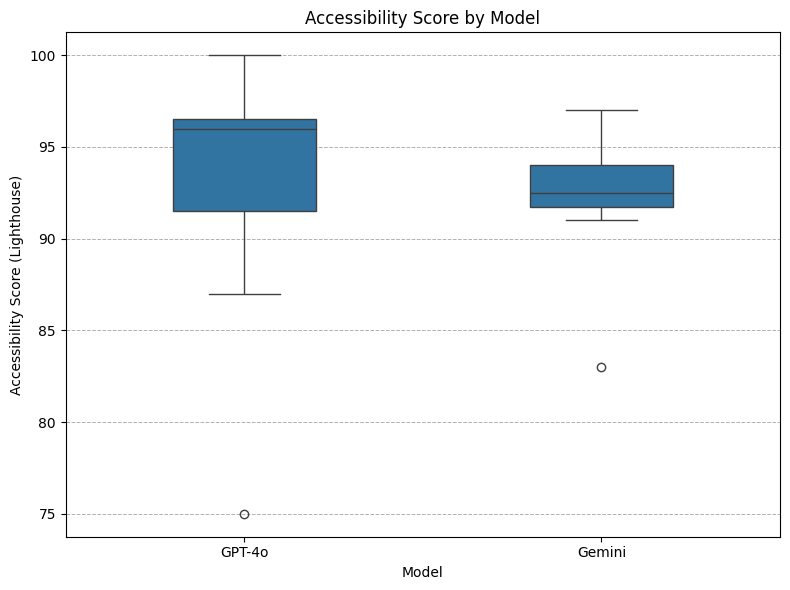

In [263]:
# Estilo visual
sns.reset_defaults()

plt.figure(figsize=(8,6))
sns.boxplot(x='Model', y='AccessibilityScore', data=df, width=0.4)
plt.title('Accessibility Score by Model')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/boxplot_accessibility_model.jpg', dpi=300)
plt.show()


#### Wave Errors por Modelo

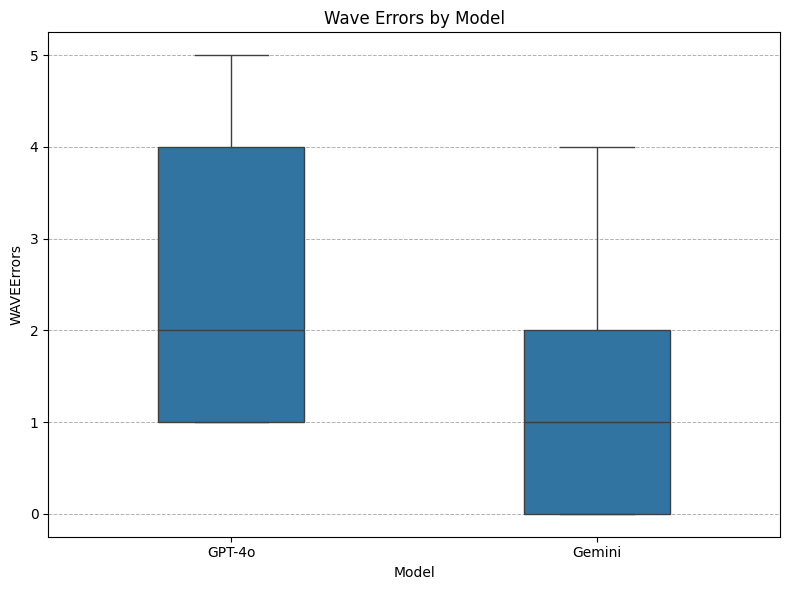

In [264]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Model', y='WAVEErrors', data=df, width=0.4)
plt.title('Wave Errors by Model')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/boxplot_waveerrors_model.jpg', dpi=300)
plt.show()

#### Accessibility Score por Input Type (HTML vs Markdown)

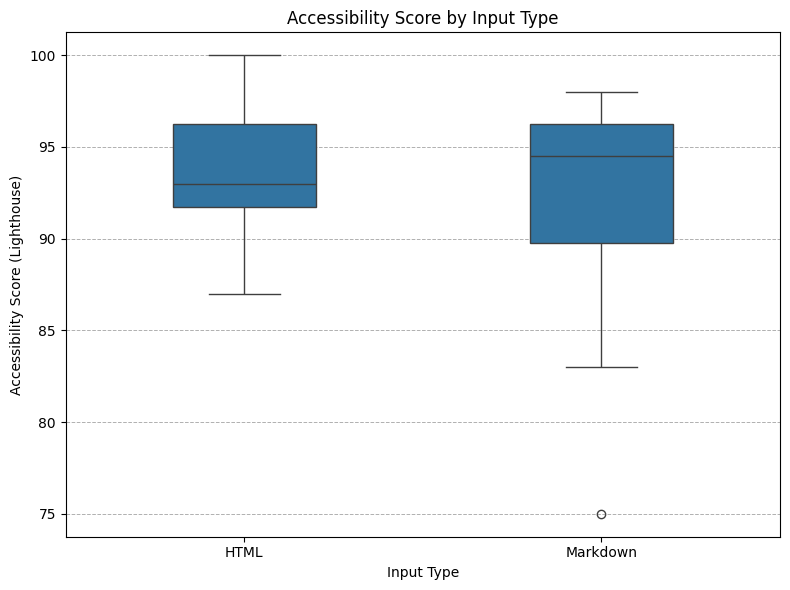

In [265]:
plt.figure(figsize=(8,6))
sns.boxplot(x='InputType', y='AccessibilityScore', data=df, width=0.4)
plt.title('Accessibility Score by Input Type')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.xlabel('Input Type')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/boxplot_accessibility_inputtype.jpg', dpi=300)
plt.show()


#### Accessibility Score por Uso de Template

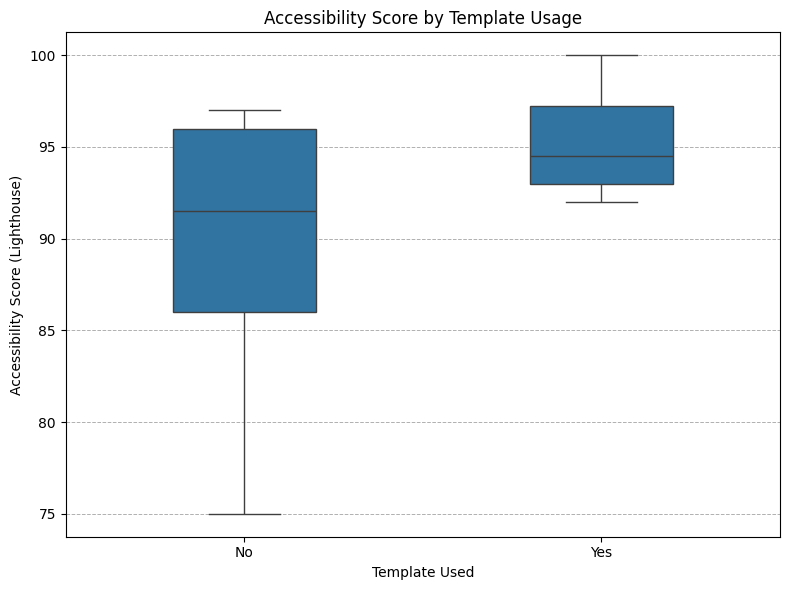

In [266]:
plt.figure(figsize=(8,6))
sns.boxplot(x='TemplateUsed', y='AccessibilityScore', data=df, width=0.4)
plt.title('Accessibility Score by Template Usage')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.xlabel('Template Used')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/boxplot_accessibility_template.jpg', dpi=300)
plt.show()


### Tokens por modelo

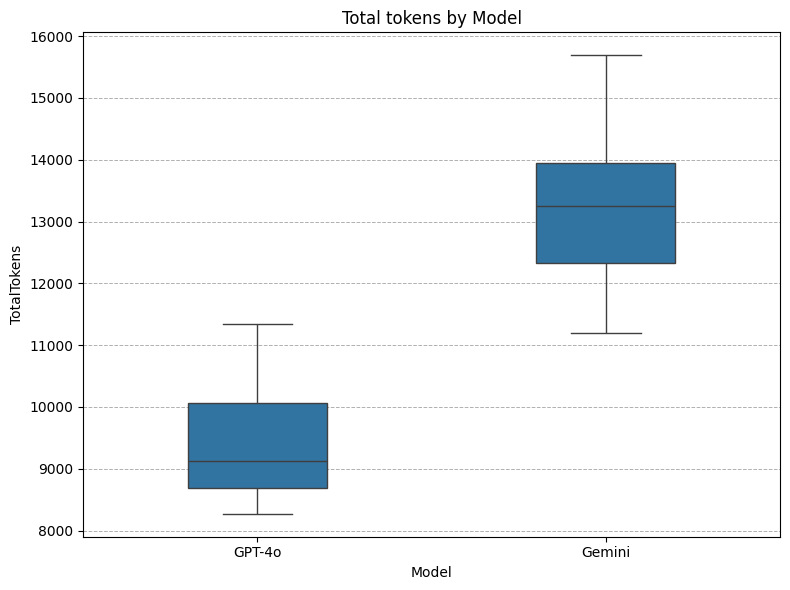

In [267]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Model', y='TotalTokens', data=df, width=0.4) 
plt.title('Total tokens by Model')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/boxplot_tokens_model.jpg', dpi=300)
plt.show()

### 2. Scatterplots — Correlaciones

#### 2.1 Tokens completion vs Accessibility Score

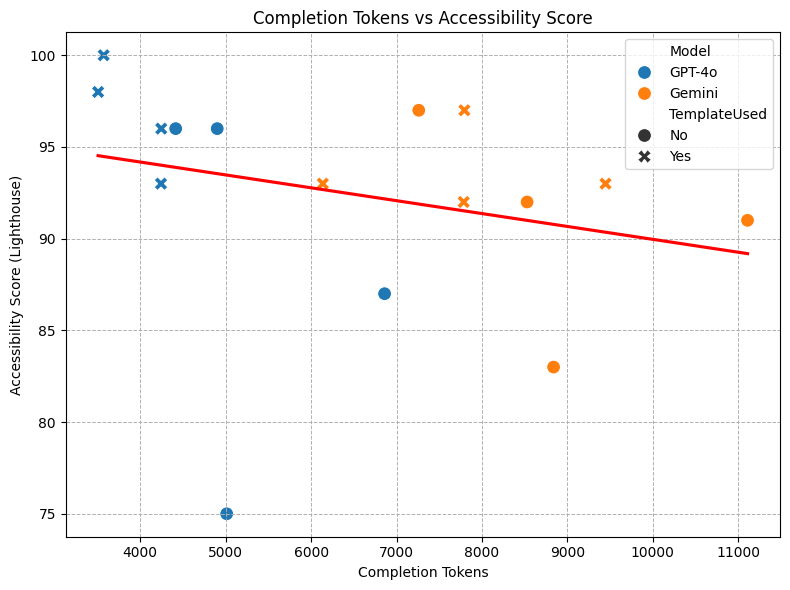

In [268]:
# Crear scatterplot
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='CompletionTokens', 
    y='AccessibilityScore', 
    hue='Model', 
    style='TemplateUsed', 
    data=df,
    s=100
)

# Añadir línea de tendencia (regresión lineal)
sns.regplot(
    x='CompletionTokens', 
    y='AccessibilityScore', 
    data=df, 
    scatter=False, 
    color='red',
    ci=None
)

plt.title('Completion Tokens vs Accessibility Score')
plt.xlabel('Completion Tokens')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.grid(linestyle='--', linewidth=0.7)
plt.tight_layout()

# Guardar imagen
plt.savefig('figures/scatter_completiontokens_vs_accessibility.jpg', dpi=300)
plt.show()

#### 2.2 Tokens usados vs Accessibility Score

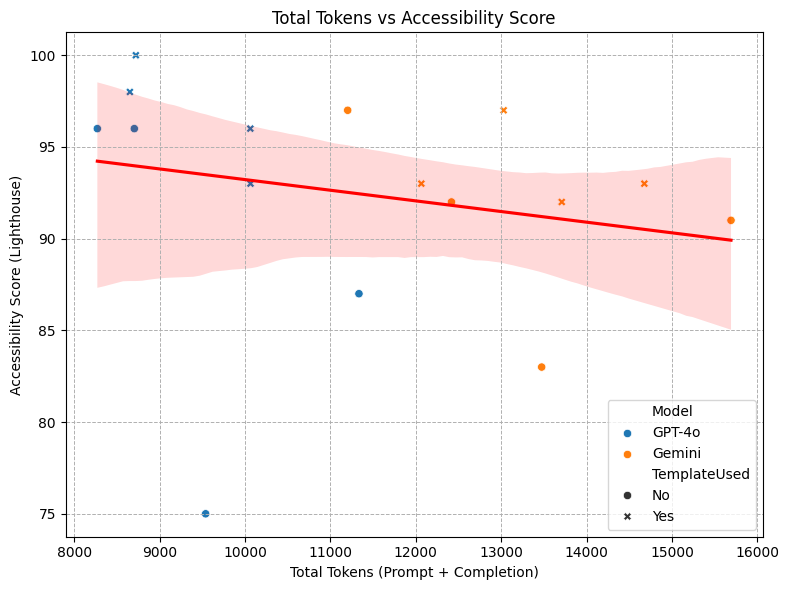

In [228]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='TotalTokens', y='AccessibilityScore', hue=df['Model'], style=df['TemplateUsed'], data=df)
sns.regplot(x='TotalTokens', y='AccessibilityScore', data=df, scatter=False, color='red')
plt.title('Total Tokens vs Accessibility Score')
plt.xlabel('Total Tokens (Prompt + Completion)')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.grid(linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/scatter_tokens_vs_accessibility_with_line.jpg', dpi=300)
plt.show()


#### 2.3 WAVE Errors vs Accessibility Score

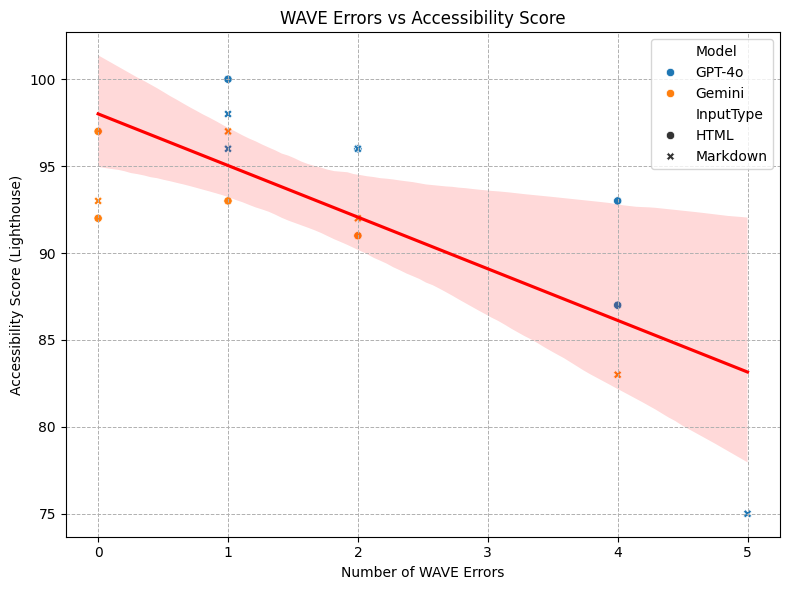

In [227]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='WAVEErrors', y='AccessibilityScore', hue=df['Model'], style=df['InputType'], data=df)
sns.regplot(x='WAVEErrors', y='AccessibilityScore', data=df, scatter=False, color='red')
plt.title('WAVE Errors vs Accessibility Score')
plt.xlabel('Number of WAVE Errors')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.grid(linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/scatter_waveerrors_vs_accessibility_with_line.jpg', dpi=300)
plt.show()



### 3. Bar charts — Comparaciones antes y después

#### 3.1 Errores WAVE Original vs Mejorados (por sitio)

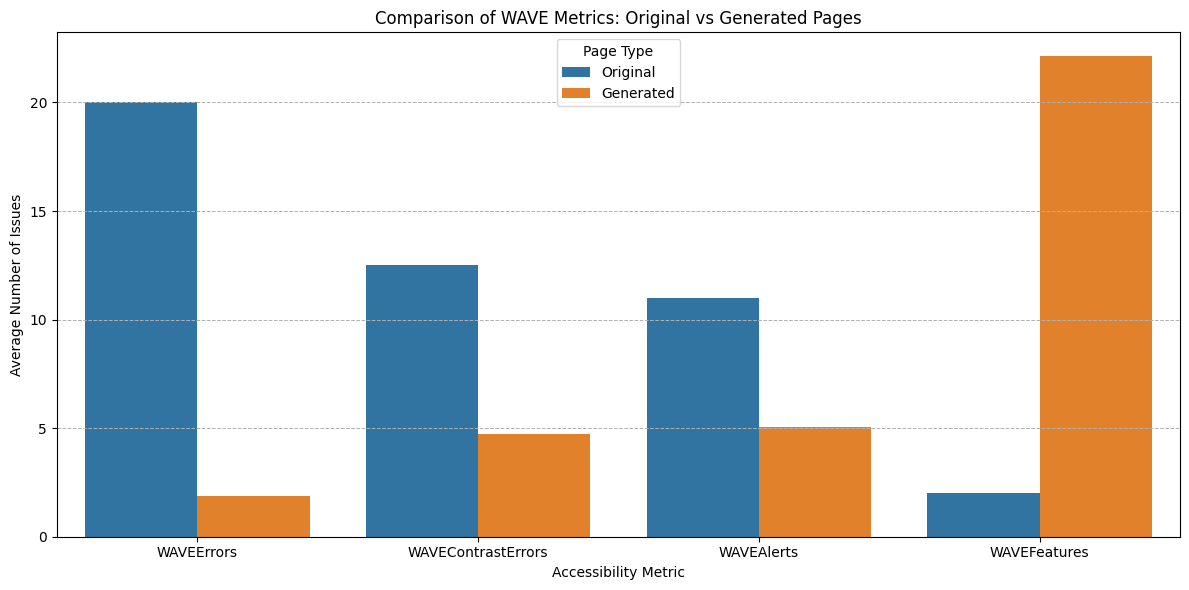

In [213]:
# Promedios de las métricas generadas
generated_metrics = df.groupby('Site')[['WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures']].mean()

# Estructurar los datos para graficar
data = []
sites = ['Site 1', 'Site 2']
metrics = ['WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures']

for site in sites:
    for metric in metrics:
        data.append({
            'Site': site,
            'Metric': metric,
            'Type': 'Original',
            'Value': original_wave_metrics[site][metric]
        })
        data.append({
            'Site': site,
            'Metric': metric,
            'Type': 'Generated',
            'Value': generated_metrics.loc[site, metric]
        })

compare_df = pd.DataFrame(data)

# Gráfica
plt.figure(figsize=(12,6))
sns.barplot(x='Metric', y='Value', hue='Type', data=compare_df, errorbar=None)
plt.title('Comparison of WAVE Metrics: Original vs Generated Pages')
plt.ylabel('Average Number of Issues')
plt.xlabel('Accessibility Metric')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.legend(title='Page Type')
plt.tight_layout()
plt.savefig('figures/bar_wave_metrics_comparison.jpg', dpi=300)
plt.show()


### Comparación de mejora usando el LightHouse score

Genera una tabla con el porcentaje de mejora respecto a la calificación original. Con esta tabla se buscara generar una gráfica de calor.

In [214]:
def generate_improvement_table(df):

    # Etiquetas ordenadas como columnas
    variant_labels = [
        'GPT-HTML', 'GPT-HTML+T', 'GPT-MD', 'GPT-MD+T',
        'Gem-HTML', 'Gem-HTML+T', 'Gem-MD', 'Gem-MD+T'
    ]

    improvement_table = []

    for site in ['Site 1', 'Site 2']:
        row = [site, original_lighthouse_scores[site]]
        for model in ['GPT-4o', 'Gemini']:
            for input_type in ['HTML', 'Markdown']:
                for template in ['No', 'Yes']:
                    score = df[
                        (df['Site'] == site) &
                        (df['Model'] == model) &
                        (df['InputType'] == input_type) &
                        (df['TemplateUsed'] == template)
                    ]['AccessibilityScore'].values[0]
                    original = original_lighthouse_scores[site]
                    improvement = round(((score - original) / original) * 100, 2)
                    row.append(improvement)
        improvement_table.append(row)

    # Mostrar tabla
    header = ['Site', 'Original'] + variant_labels
    print("{:<8} {:<10} ".format(header[0], header[1]) + " ".join(f"{col:<13}" for col in header[2:]))

    for row in improvement_table:
        print("{:<8} {:<10} ".format(row[0], row[1]) + " ".join(f"{val:<13}" for val in row[2:]))
        
generate_improvement_table(df)

Site     Original   GPT-HTML      GPT-HTML+T    GPT-MD        GPT-MD+T      Gem-HTML      Gem-HTML+T    Gem-MD        Gem-MD+T     
Site 1   69         39.13         44.93         39.13         42.03         33.33         40.58         40.58         34.78        
Site 2   58         50.0          60.34         29.31         65.52         56.9          60.34         43.1          58.62        


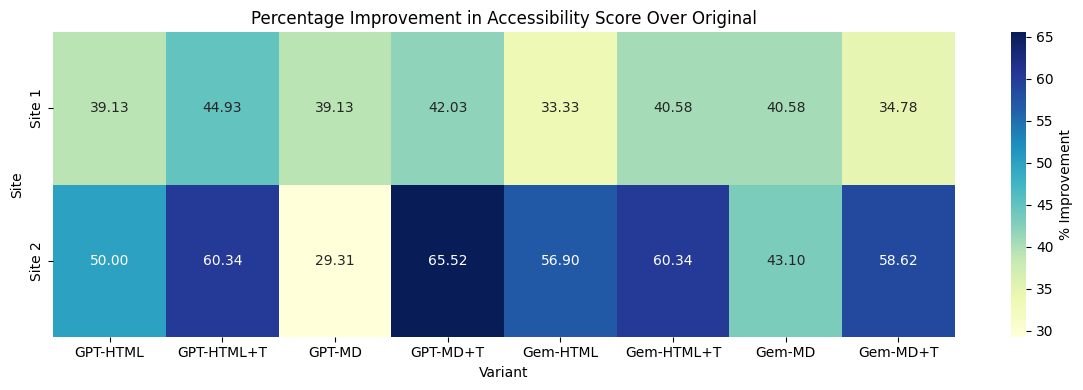

In [217]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

def save_improvement_heatmap(df, output_path='figures/heatmap_accessibility_improvement.jpg'):
    # Crear carpeta si no existe
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Etiquetas
    variant_labels = [
        'GPT-HTML', 'GPT-HTML+T', 'GPT-MD', 'GPT-MD+T',
        'Gem-HTML', 'Gem-HTML+T', 'Gem-MD', 'Gem-MD+T'
    ]

    improvement_table = []

    for site in ['Site 1', 'Site 2']:
        row = [site, original_lighthouse_scores[site]]
        for model in ['GPT-4o', 'Gemini']:
            for input_type in ['HTML', 'Markdown']:
                for template in ['No', 'Yes']:
                    score = df[
                        (df['Site'] == site) &
                        (df['Model'] == model) &
                        (df['InputType'] == input_type) &
                        (df['TemplateUsed'] == template)
                    ]['AccessibilityScore'].values[0]
                    original = original_lighthouse_scores[site]
                    improvement = round(((score - original) / original) * 100, 2)
                    row.append(improvement)
        improvement_table.append(row)

    # Crear heatmap
    header = ['Site', 'Original'] + variant_labels
    df_plot = pd.DataFrame(improvement_table, columns=header).set_index('Site')
    df_plot = df_plot.drop(columns='Original')

    plt.figure(figsize=(12, 4))
    sns.heatmap(df_plot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': '% Improvement'})
    plt.title('Percentage Improvement in Accessibility Score Over Original')
    plt.xlabel('Variant')
    plt.ylabel('Site')
    plt.tight_layout()
    plt.savefig(output_path, format='jpg', dpi=300)
    plt.show()
    plt.close()

save_improvement_heatmap(df)